In [1]:
!nvidia-smi

Sat Oct 15 11:01:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os
import sys
import random
import tensorflow as tf
from pathlib import Path
from six.moves import urllib
import tarfile
import shutil

from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model

from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [3]:
target_size = (224, 224)

inception_model = InceptionV3(weights='imagenet', input_shape = target_size + (3,), include_top=False)


87910968/87910968 [==============================] - 0s 0us/step


In [4]:
flat_layer = layers.Flatten()(inception_model.output)
dense_layer_1 = layers.Dense(512, activation='relu')(flat_layer)
dense_layer_1 = layers.BatchNormalization()(dense_layer_1)
dense_layer_2 = layers.Dense(256, activation='relu')(dense_layer_1)
dense_layer_2 = layers.BatchNormalization()(dense_layer_2)
dense_layer_3 = layers.Dense(128, activation='relu')(dense_layer_2)

for layer in inception_model.layers:
    layer.trainable = False

#define a model with the layers we've just connected
transfer_inception_model = Model(inputs = inception_model.inputs, outputs = dense_layer_3)

In [37]:
class SimilarityLayer(layers.Layer):
    # compute and return the two distances:
    # d(anchor,positive) 
    # d(anchor,negative)
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, anchor, positive, negative):
        d1 = tf.reduce_sum(tf.square(anchor-positive), -1)
        d2 = tf.reduce_sum(tf.square(anchor-negative), -1)
        return(d1,d2)
    
anchor = layers.Input(name='anchor', shape = target_size + (3,))
positive = layers.Input(name='positive', shape = target_size + (3,))
negative = layers.Input(name='negative', shape = target_size + (3,))

sim_layer_output = SimilarityLayer().call(
    transfer_inception_model(inputs = inception_v3.preprocess_input(anchor)),
    transfer_inception_model(inputs = inception_v3.preprocess_input(positive)),
    transfer_inception_model(inputs = inception_v3.preprocess_input(negative))
)

siamese_model = Model(inputs=[anchor, positive,negative], outputs=sim_layer_output)

In [38]:
class SiameseModelClass(Model):
    def __init__(self, siamese_model, margin = 0.5):
        super(SiameseModelClass, self).__init__()
        
        self.siamese_model = siamese_model
        self.margin = margin
        
        # create a Metric instance to track the loss
        self.loss_tracker = metrics.Mean(name="loss")
        
    def call(self, inputs):
        return self.siamese_model(inputs)
    
    # customize the training process: providing our own training step
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # call custom loss function
            loss = self.custom_loss(data)
            
        # Compute gradients
        trainable_vars = self.siamese_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update our training loss metric
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}
    
    # providing our own evaluation step
    def test_step(self, data):
        # call custom loss function
        loss = self.custom_loss(data)
        
        # Update our test loss metric
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}
    
    # custom loss function
    def custom_loss(self, data):
        # get the distances tuple from the siamese model output
        d1, d2 = self.siamese_model(data)
        
        # compute the triplet loss
        loss = tf.maximum(d1 - d2 + self.margin, 0)
        
        return loss
    @property
    def metrics(self):
        return [self.loss_tracker]

#Dataset

In [5]:
!gdown 16MM4uDPjAdJVf62kd9CYRLRCi33cZS7-

Downloading...
From: https://drive.google.com/uc?id=16MM4uDPjAdJVf62kd9CYRLRCi33cZS7-
To: /content/"facenet.zip"
100% 14.1M/14.1M [00:00<00:00, 60.1MB/s]


In [ ]:
!unzip '/content/"facenet.zip"'
!rm '/content/"facenet.zip"'

In [7]:
selection_folder = "/content/content/contents/data/lfw_selection/"
subfolders = [x[0] for x in os.walk(selection_folder)]

In [10]:
people_list = []

for path in subfolders:
    image_count = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    people_list.append((path.split('\\')[-1], image_count))
    #people_count.append((path, image_count))
    
# Sort from max to min images per person
people_list = sorted(people_list, key=lambda x: x[1], reverse=True)

In [12]:
# dictionary of selected persons, where 
# - key = rank
# - value = list of names of the image files for this person
selected_persons = {}
i = 0

for person,image_count in people_list:
    file_list = []
    newpath = selection_folder + '/' + person.split('/')[-1]
    #if not os.path.exists(newpath):
    #    os.makedirs(newpath)
        
    files = [os.path.join(person, f) for f in os.listdir(person) if os.path.isfile(os.path.join(person, f))]
    files = files[0:10] 
    for file in files:
        filename = file.split('/')[-1]
        file_list.append(newpath + '/' + filename)
            
        selected_persons[i] = file_list
        i = i + 1

In [39]:
triplets = []

for item in selected_persons.items():
    images = item[1]
    
    for i in range(len(images)-1):
        for j in range(i+1,len(images)):
            anchor = images[i]
            positive = images[j]
            
            # choose a random negative
            # first generate a random class rank and make sure we're not selecting the current class
            random_class = item[0]
            while random_class == item[0]:
                random_class = random.randint(0, len(selected_persons)-1)
            # selected a random image from the 10 that any of our classes has
            random_image = random.randint(0, 9)
            negative = selected_persons[random_class][random_image]
            
            triplets.append((anchor, positive, negative))

In [40]:
# helper function for needed preprocessing of our jpg images
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels = 3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_size)
    return image

In [41]:
def plot_images(triplets):
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    fig = plt.figure(figsize=(7,12))
    axis = fig.subplots(5, 3)
    
    for i in range(0,5):
        anchor,positive,negative = triplets[40+i]
        show(axis[i,0], preprocess_image(anchor))
        show(axis[i,1], preprocess_image(positive))
        show(axis[i,2], preprocess_image(negative))

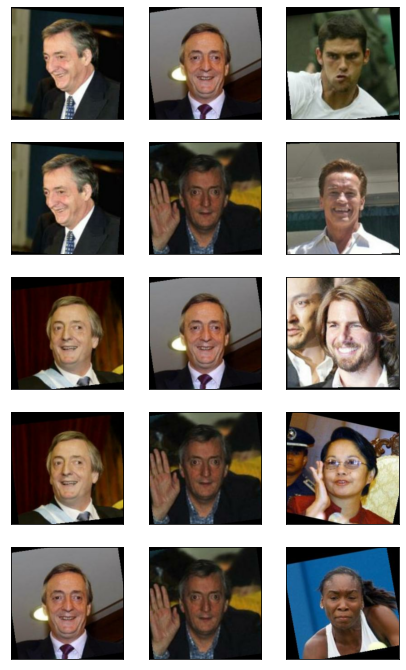

In [22]:
plot_images(triplets)

In [42]:
# helper function for transforming a tuple of filenames 
# into a tuple of corresponding tensors
def preprocess_triplets(anchor, positive, negative):
    """
    Inputs: a tuple of filenames
    Output: a tuple of preprocessed images 
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative)
    )

In [43]:
rng = np.random.RandomState(seed=101)
rng.shuffle(triplets)

In [44]:
anchor_images = [a_tuple[0] for a_tuple in triplets]
positive_images = [a_tuple[1] for a_tuple in triplets]
negative_images = [a_tuple[2] for a_tuple in triplets]

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

In [45]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))

training_data = dataset.take(train_size)
remaining_data = dataset.skip(train_size)
test_data = remaining_data.take(val_size)
validation_data = remaining_data.skip(val_size)

training_data = training_data.batch(64, drop_remainder=False)
training_data = training_data.prefetch(8)

validation_data = validation_data.batch(64, drop_remainder=False)
validation_data = validation_data.prefetch(8)

test_data = test_data.batch(64, drop_remainder=False)
test_data = test_data.prefetch(8)

In [46]:
model_on_GPU = SiameseModelClass(siamese_model)
model_on_GPU.compile(optimizer = optimizers.Adam(0.0001))

device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import time
start = time.time()

epochs = 15
with tf.device('/gpu:0'):
    history = model_on_GPU.fit(
        training_data, 
        epochs=epochs, 
        validation_data = validation_data
    )
stop = time.time()
print(f'Training on GPU took: {(stop-start)/60} minutes')

Epoch 1/15
889/889 [==============================] - ETA: 0s - loss: 0.1902

889/889 [==============================] - 606s 657ms/step - loss: 0.1902 - val_loss: 0.0793
Epoch 2/15
889/889 [==============================] - ETA: 0s - loss: 0.0486

889/889 [==============================] - 573s 644ms/step - loss: 0.0486 - val_loss: 0.0402
Epoch 3/15
889/889 [==============================] - ETA: 0s - loss: 0.0297

889/889 [==============================] - 573s 644ms/step - loss: 0.0297 - val_loss: 0.0317
Epoch 4/15
889/889 [==============================] - ETA: 0s - loss: 0.0217

889/889 [==============================] - 573s 645ms/step - loss: 0.0217 - val_loss: 0.0317
Epoch 5/15
889/889 [==============================] - ETA: 0s - loss: 0.0180

889/889 [==============================] - 571s 643ms/step - loss: 0.0180 - val_loss: 0.0224
Epoch 6/15
889/889 [==============================] - ETA: 0s - loss: 0.0148

889/889 [==============================] - 571s 642ms/step - loss: 0.0148 - val_loss: 0.0267
Epoch 7/15
889/889 [==============================] - ETA: 0s - loss: 0.0130

889/889 [==============================] - 569s 641ms/step - loss: 0.0130 - val_loss: 0.0277
Epoch 8/15
889/889 [==============================] - ETA: 0s - loss: 0.0117

889/889 [==============================] - 569s 640ms/step - loss: 0.0117 - val_loss: 0.0227
Epoch 9/15
889/889 [==============================] - ETA: 0s - loss: 0.0096

889/889 [==============================] - 570s 641ms/step - loss: 0.0096 - val_loss: 0.0168
Epoch 10/15
889/889 [==============================] - ETA: 0s - loss: 0.0093

889/889 [==============================] - 570s 642ms/step - loss: 0.0093 - val_loss: 0.0240
Epoch 11/15
889/889 [==============================] - ETA: 0s - loss: 0.0081

889/889 [==============================] - 578s 650ms/step - loss: 0.0081 - val_loss: 0.0157
Epoch 12/15
889/889 [==============================] - ETA: 0s - loss: 0.0072

889/889 [==============================] - 587s 660ms/step - loss: 0.0072 - val_loss: 0.0210
Epoch 13/15
889/889 [==============================] - ETA: 0s - loss: 0.0067

889/889 [==============================] - 586s 660ms/step - loss: 0.0067 - val_loss: 0.0156
Epoch 14/15
889/889 [==============================] - ETA: 0s - loss: 0.0061

889/889 [==============================] - 584s 657ms/step - loss: 0.0061 - val_loss: 0.0161
Epoch 15/15
246/889 [=======>......................] - ETA: 4:43 - loss: 0.0062

In [ ]:
sample = next(iter(training_data))
#plot_images(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    transfer_inception_model(inputs = inception_v3.preprocess_input(anchor)),
    transfer_inception_model(inputs = inception_v3.preprocess_input(positive)),
    transfer_inception_model(inputs = inception_v3.preprocess_input(negative)),
)

#Bài tập 


1. Chạy FaceNet với mạng Inception có tính learnable
2. Hãy thay mạng inception bằng mạng VGG-16 và tiến hành train mạng FaceNet
3. Viết một function nhận ba tấm ảnh lần lượt là anchor, positive và negative, function này sẽ tính d(anchor,  positive), d(anchor, negative), và cho biết khoảng cách nào lớn hơn (trên tập test)